# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [ ]:
!nvidia-smi

Fri May 20 09:47:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq -U pandas

In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training and test data will be combined into a single data frame. This will give us more data to train our Autoencoder.

In [ ]:
from google.colab import drive
from datetime import datetime
drive.mount('/content/gdrive', force_remount=True)


from sklearn import preprocessing

def read_csv_kairos(path):
  df = pd.read_csv(path)
  df = df.iloc[: , 1:]
  return df
dfw = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/dset/kairos_csv/kairos_window.csv")

x = dfw.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfw = pd.DataFrame(x_scaled)
dfw['target'] = 'Window'

dfn = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/dset/kairos_csv/kairos_normal.csv")
x = dfn.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfn = pd.DataFrame(x_scaled)
dfn['target'] = 'Normal'

df = dfn.append(dfw)

df.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z","target"
]

Mounted at /content/gdrive


In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11287 entries, 0 to 5741
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11287 non-null  float64
 1   1       11287 non-null  float64
 2   2       11287 non-null  float64
 3   3       11287 non-null  float64
 4   4       11287 non-null  float64
 5   5       11287 non-null  float64
 6   6       11287 non-null  float64
 7   7       11287 non-null  float64
 8   8       11287 non-null  float64
 9   9       11287 non-null  float64
 10  10      11287 non-null  float64
 11  11      11287 non-null  float64
 12  12      11287 non-null  float64
 13  13      11287 non-null  float64
 14  14      11287 non-null  float64
 15  15      11287 non-null  float64
 16  16      11287 non-null  float64
 17  17      11287 non-null  float64
 18  18      11287 non-null  float64
 19  19      11287 non-null  float64
 20  20      11287 non-null  float64
 21  21      11287 non-null  float64
 22 

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,target
0,0.000000,0.974337,0.980965,0.997950,0.044766,0.0,0.000673,0.0,0.000338,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
1,0.000004,0.954724,0.980759,0.997863,0.045110,0.0,0.000673,0.0,0.000338,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
2,0.000036,0.932871,0.980479,0.997947,0.044766,0.0,0.000337,0.0,0.000675,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
3,0.000547,0.905251,0.980136,0.996939,0.045110,0.0,0.000673,0.0,0.000000,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
4,0.001443,0.874419,0.979738,0.996821,0.045110,0.0,0.000673,0.0,0.000000,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal


In [ ]:
CLASS_NORMAL = 'Normal'

class_names = ['Normal','Window']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [ ]:
# new_columns = list(df.columns)
# new_columns[-1] = 'target'
# df.columns = new_columns

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [ ]:
df.target.value_counts()

Window    5742
Normal    5545
Name: target, dtype: int64

Let's plot the results:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


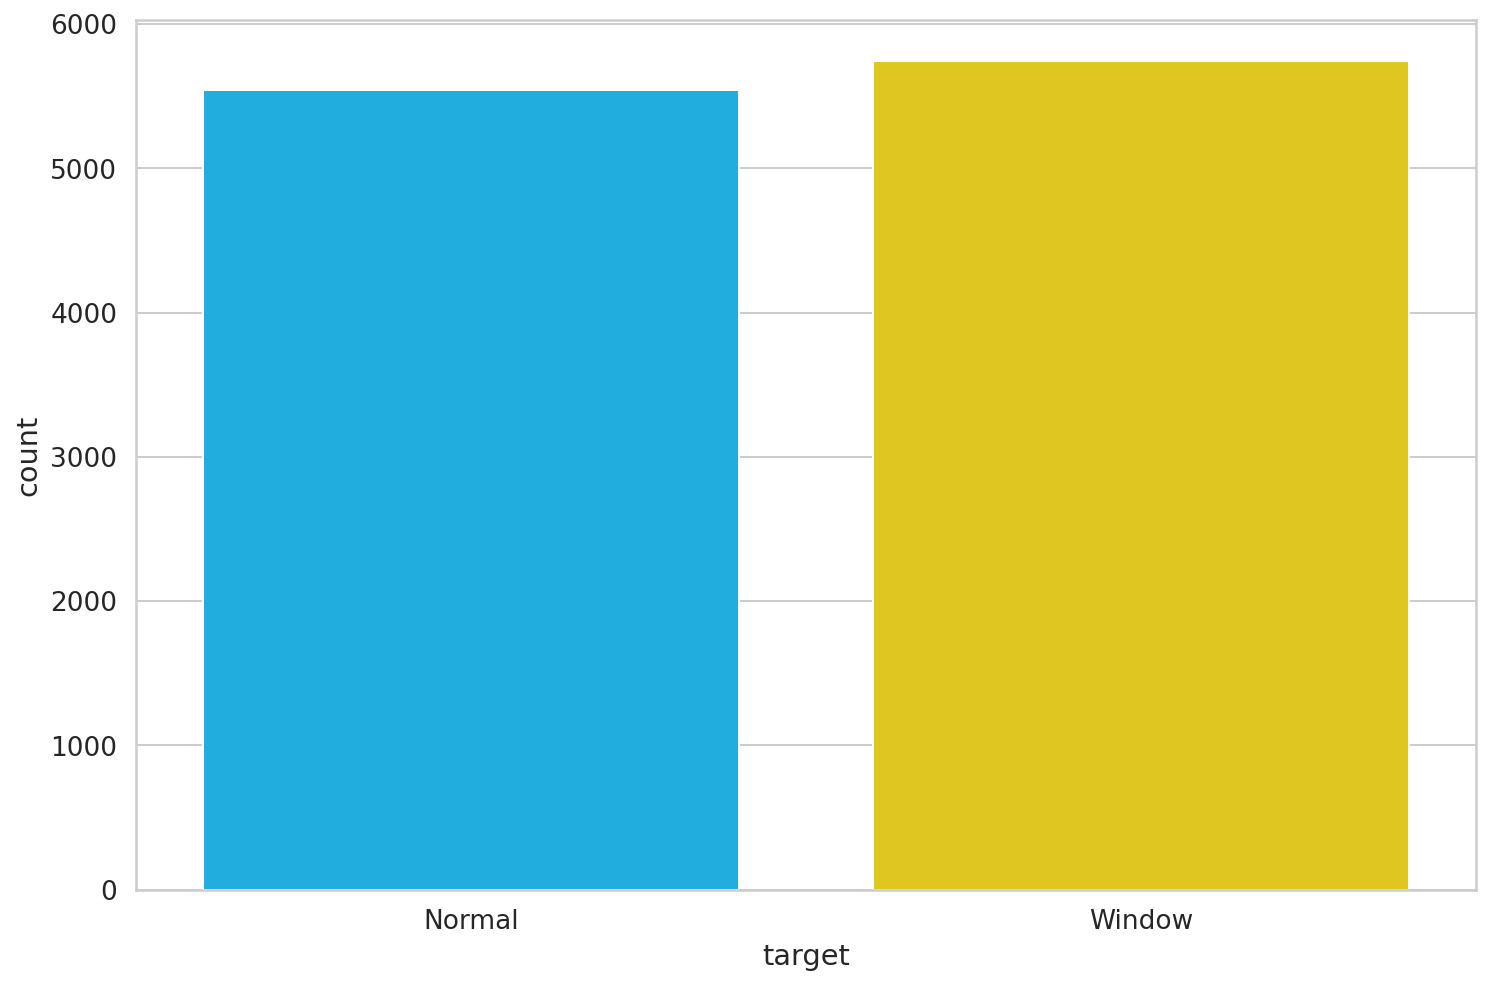

In [ ]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

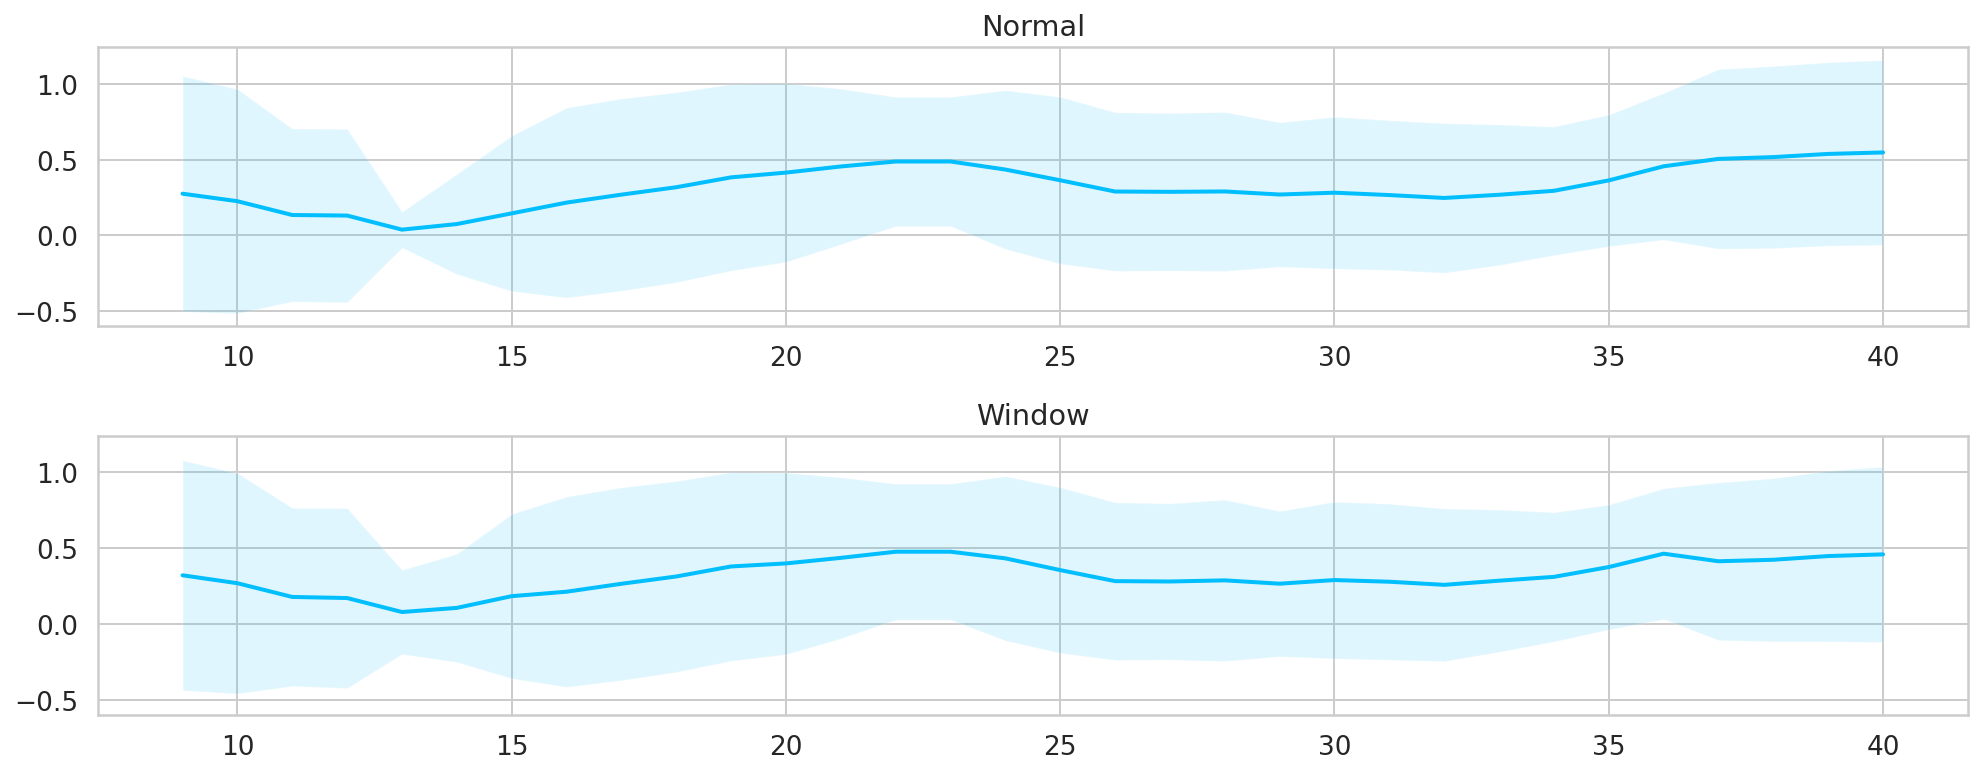

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 1+1,
  ncols=1,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [ ]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(5545, 41)

We'll merge all other classes and mark them as anomalies:

In [ ]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(5742, 41)

We'll split the normal examples into train, validation and test sets:

In [ ]:
train_df, test_df = train_test_split(
  normal_df,
  test_size=0.20,
  random_state=RANDOM_SEED
)

train_df, val_df = train_test_split(
  train_df,
  test_size=0.10, 
  random_state=RANDOM_SEED
)

print(train_df.shape, val_df.shape, test_df.shape)

(3992, 41) (444, 41) (1109, 41)


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float64).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    
    self.input = (seq_len, n_features, embedding_dim)
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

Let's write a helper function for our training process:

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=25#150
)

Epoch 1: train loss 4.273262305047087 val loss 2.305310683341714
Epoch 2: train loss 2.462222366905463 val loss 1.97749285634842
Epoch 3: train loss 2.5870690408399803 val loss 1.824587832700025
Epoch 4: train loss 2.41992801928777 val loss 1.8061997352151182
Epoch 5: train loss 2.1258462997179532 val loss 1.677528830866019
Epoch 6: train loss 1.495552055701942 val loss 1.4654377397518974
Epoch 7: train loss 1.286773416010256 val loss 1.2365701187167082
Epoch 8: train loss 1.1590469579374743 val loss 1.1470484054638996
Epoch 9: train loss 1.0790069279408376 val loss 1.1113874817619454
Epoch 10: train loss 1.044316056630535 val loss 0.9942109050850073
Epoch 11: train loss 0.9620097359933542 val loss 0.971961214299406
Epoch 12: train loss 0.928920009584056 val loss 0.921755585081137
Epoch 13: train loss 0.8803682967811405 val loss 0.8206851923720794
Epoch 14: train loss 0.8362418393957203 val loss 0.8372734545788787
Epoch 15: train loss 0.8016246133418623 val loss 0.8169776273404693
Epoc

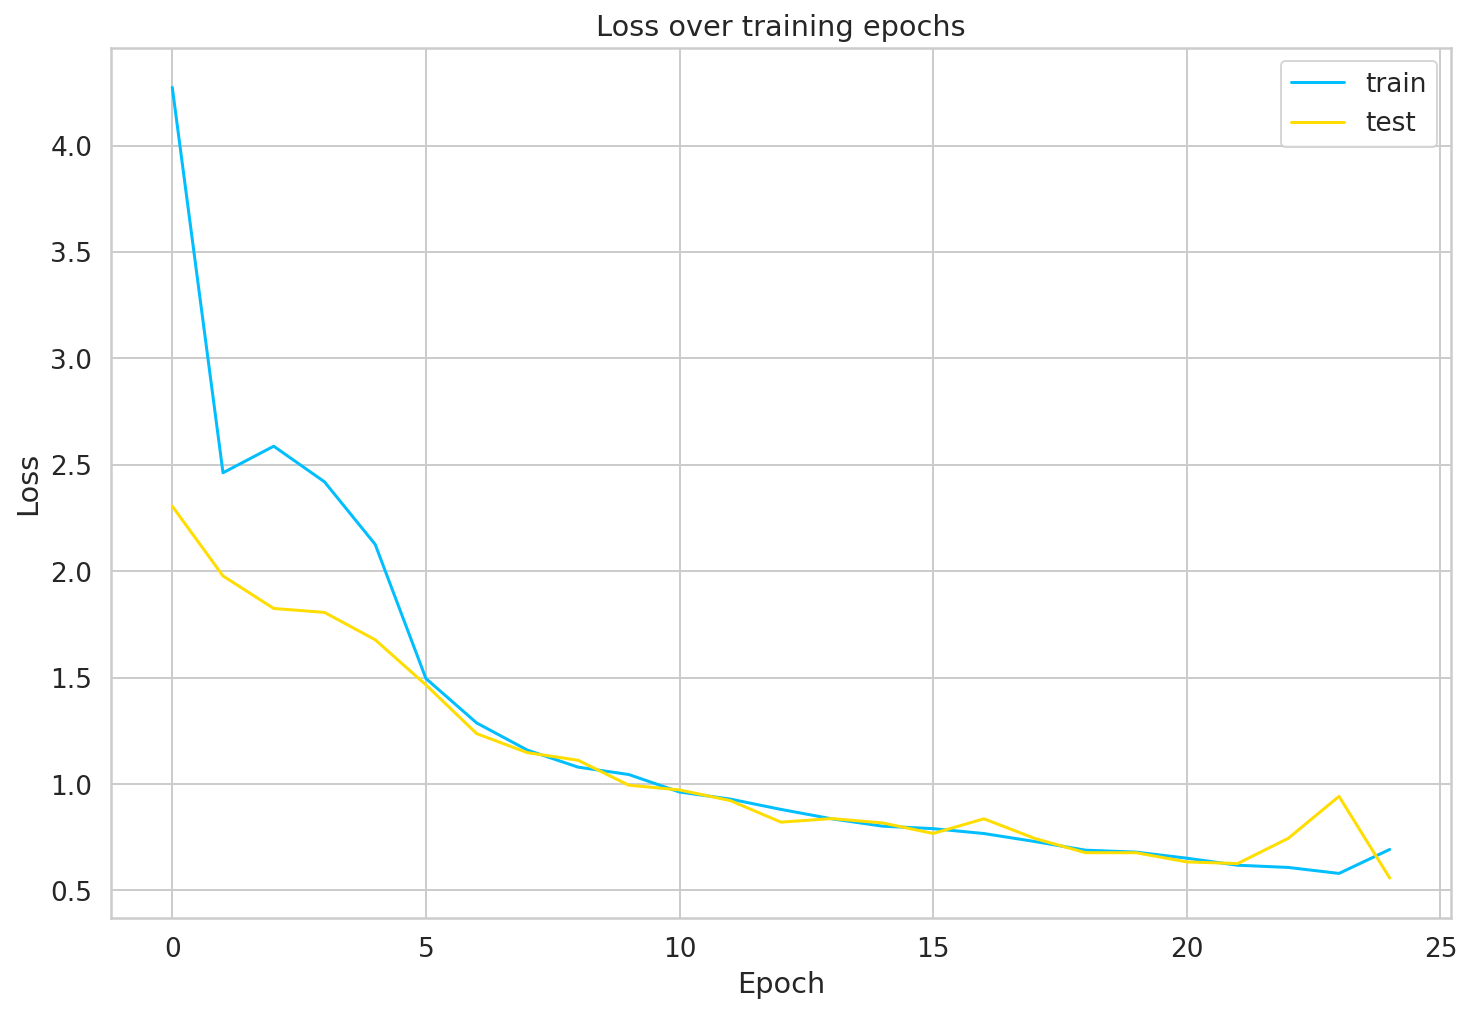

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = '/content/gdrive/My Drive/MOBILE_ROBOTICS/models/model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('/content/gdrive/My Drive/MOBILE_ROBOTICS/models/model.pth')
model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


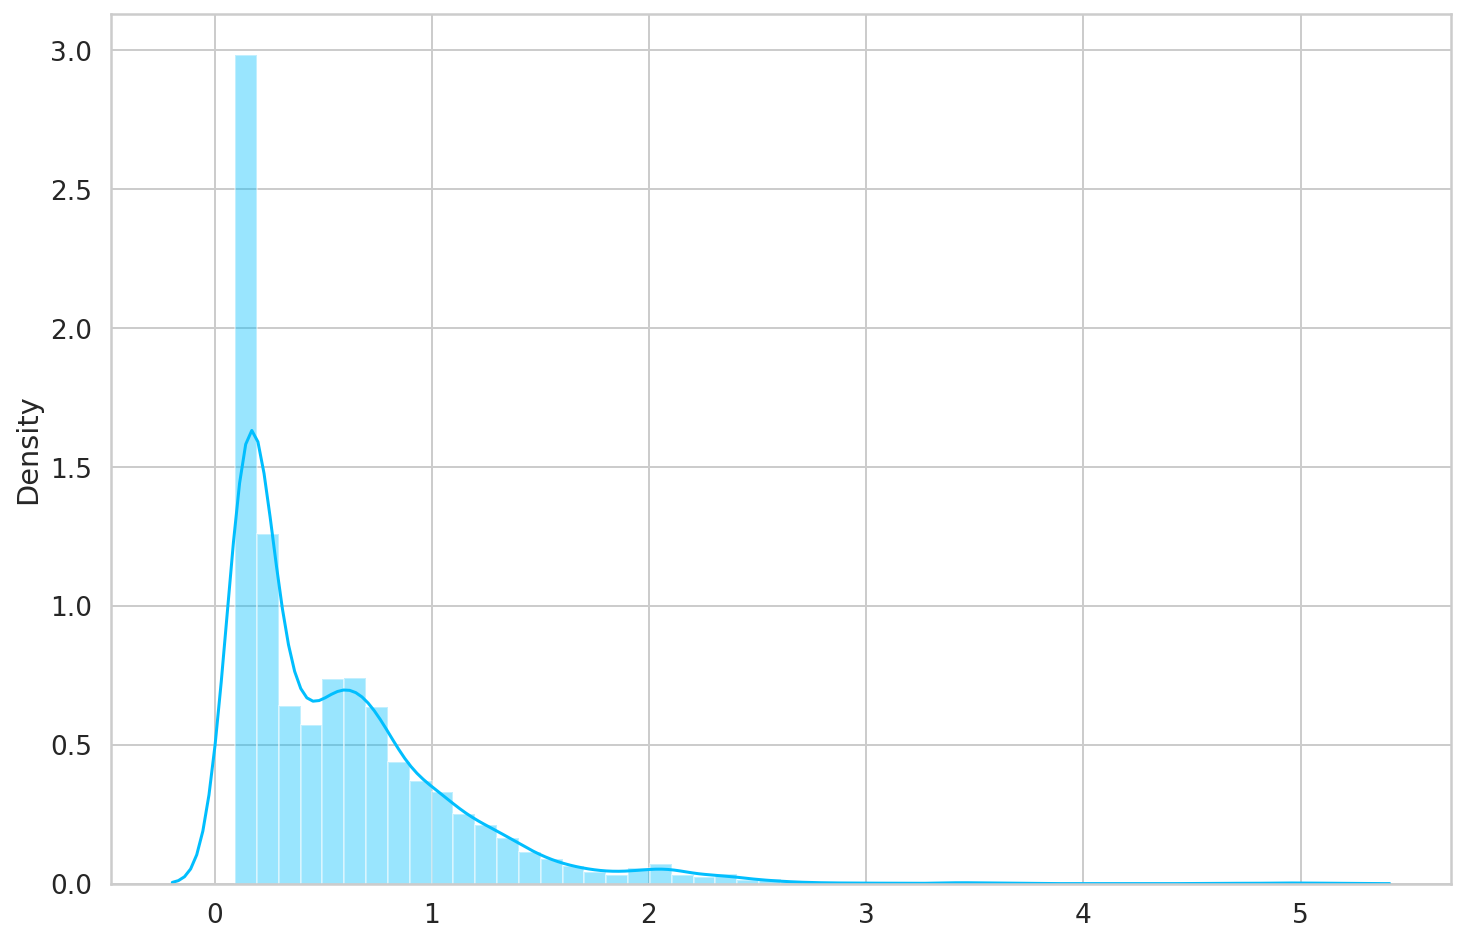

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 3.1#2.75#26

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

In [ ]:
from sklearn import metrics
def test_sklearn(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  recall = metrics.recall_score(y_true, y_pred, pos_label=True)
  precision = metrics.precision_score(y_true, y_pred, pos_label=True)
  f1 = metrics.f1_score(y_true, y_pred, pos_label=True)
  roc_auc = metrics.roc_auc_score(y_true, y_pred)

  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  print('Accuracy: %f' % accuracy)
  print('Roc auc score: %f' % roc_auc)
  print('%f\t%f\t%f\t%f' % (precision,recall,f1,accuracy))
  print(metrics.precision_recall_fscore_support(y_true, y_pred))

  #index = ['normal', 'attack']
  index = ['window','normal']
  df_confusion = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), index=index, columns=index)
  _, ax = plt.subplots()
  sns.heatmap(df_confusion, cmap='Blues', annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  #fix bug in lib, info: https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
  #bottom, top = ax.get_ylim()
  #ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  plt.figure(1)
  plt.plot(fpr, tpr, label=('ROC curve (area = %0.2f)'%roc_auc))
  plt.plot([0,1],[0,1],'r--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  # precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(y_true, y_pred)
  # plt.figure(1)
  # plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
  # plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
  # plt.title('Precision and recall for different threshold values')
  # plt.xlabel('Threshold')
  # plt.ylabel('Precision/Recall')
  # plt.legend()
  # plt.show()

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


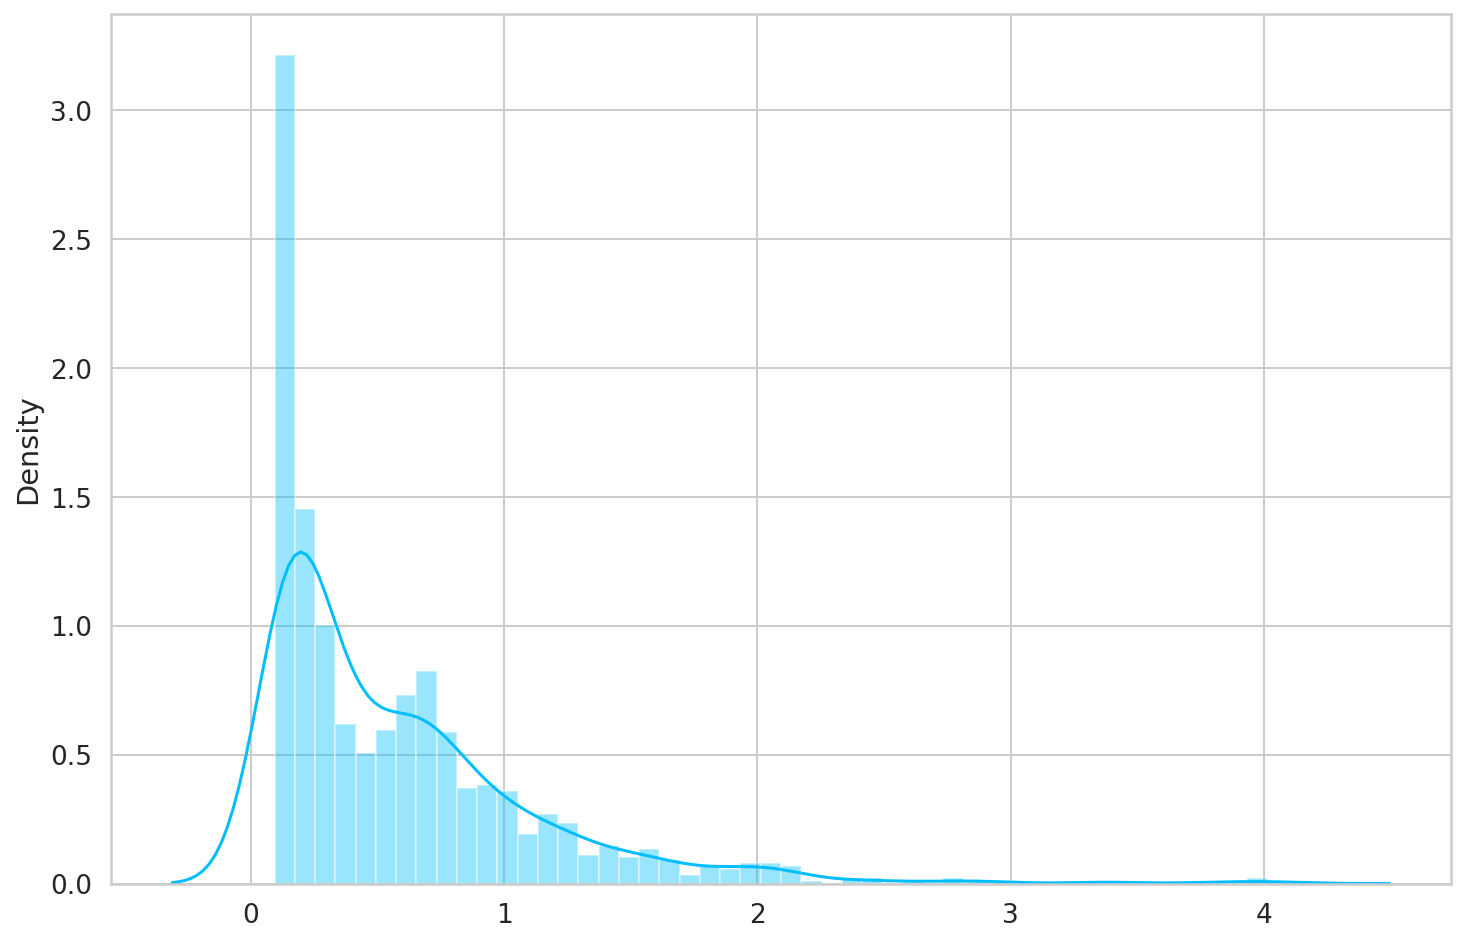

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 1103/1109


In [ ]:
correct_normal = [l <= THRESHOLD for l in pred_losses]
print(correct_normal)

pred_losses_normal = [True for i in range(len(correct_normal))]
print(pred_losses_normal)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [ ]:
anomaly_dataset = test_anomaly_dataset#[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


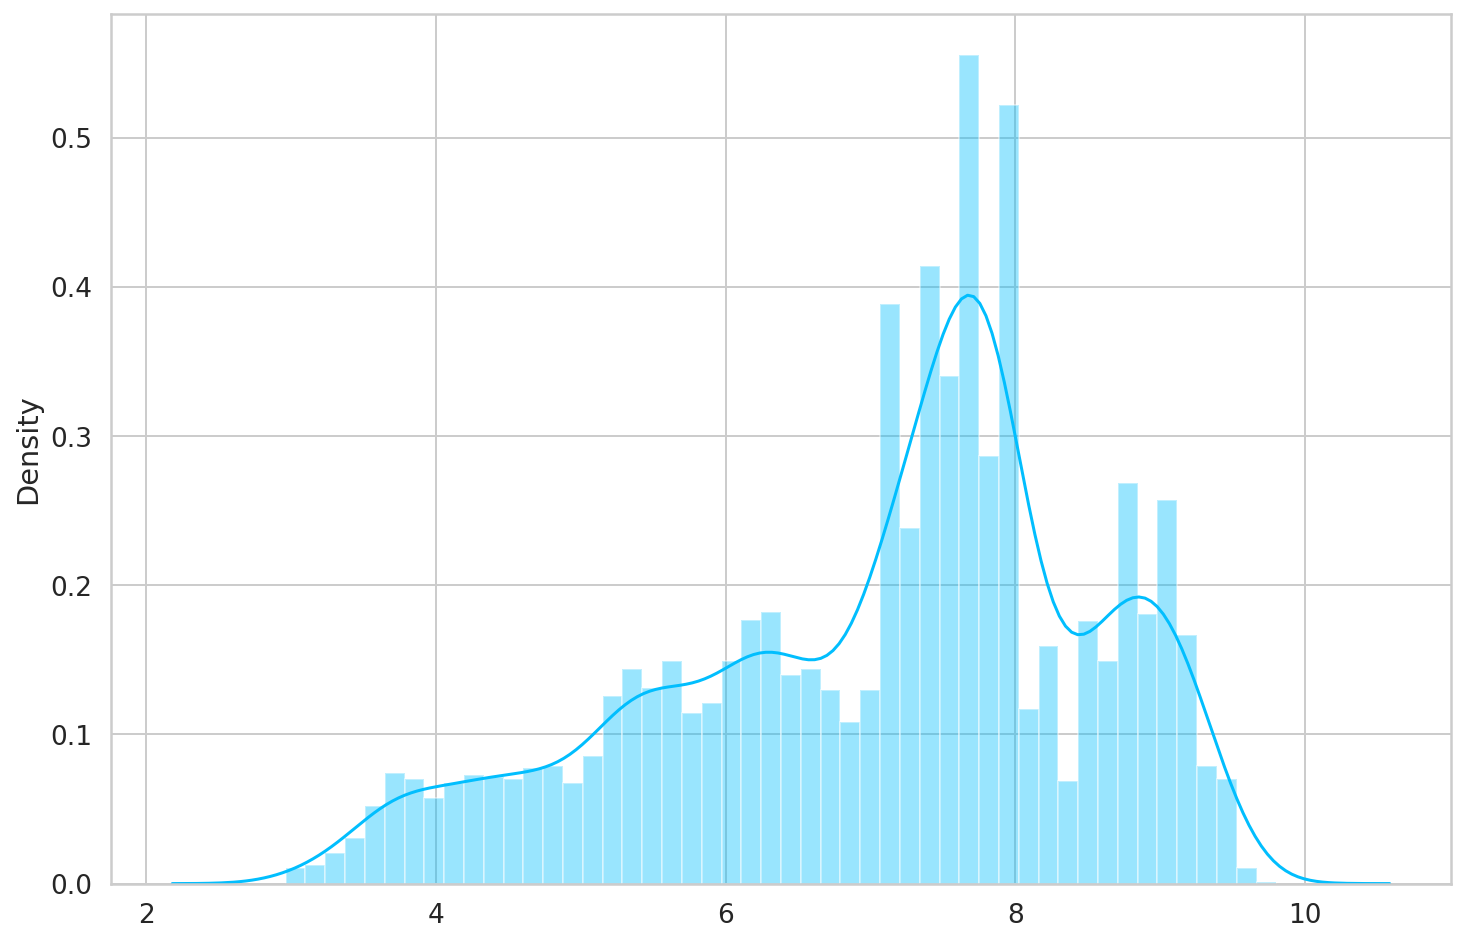

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 5734/5742


In [ ]:
correct_anomaly = [l <= THRESHOLD for l in pred_losses]
print(correct_anomaly)
print(len(correct_anomaly))
pred_losses_anomaly = [False for i in range(len(correct_anomaly))]
print(pred_losses_anomaly)
print(len(pred_losses_anomaly))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa

In [ ]:
## Convert to integers

# normal class is 1
correct_normal = list(map(int,correct_normal))
print(sum(correct_normal), len(correct_normal))
pred_losses_normal = list(map(int,pred_losses_normal))
print(sum(pred_losses_normal), len(pred_losses_normal))

# anomaly class is 0
correct_anomaly = list(map(int,correct_anomaly))
print(sum(correct_anomaly), len(correct_anomaly))
pred_losses_anomaly = list(map(int,pred_losses_anomaly))
print(sum(pred_losses_anomaly), len(pred_losses_anomaly))

1103 1109
1109 1109
8 5742
0 5742


Precision: 0.992799
Recall: 0.994590
F1 score: 0.993694
Accuracy: 0.997957
Roc auc score: 0.996598
0.992799	0.994590	0.993694	0.997957
(array([0.9989547 , 0.99279928]), array([0.99860676, 0.99458972]), array([0.9987807 , 0.99369369]), array([5742, 1109]))


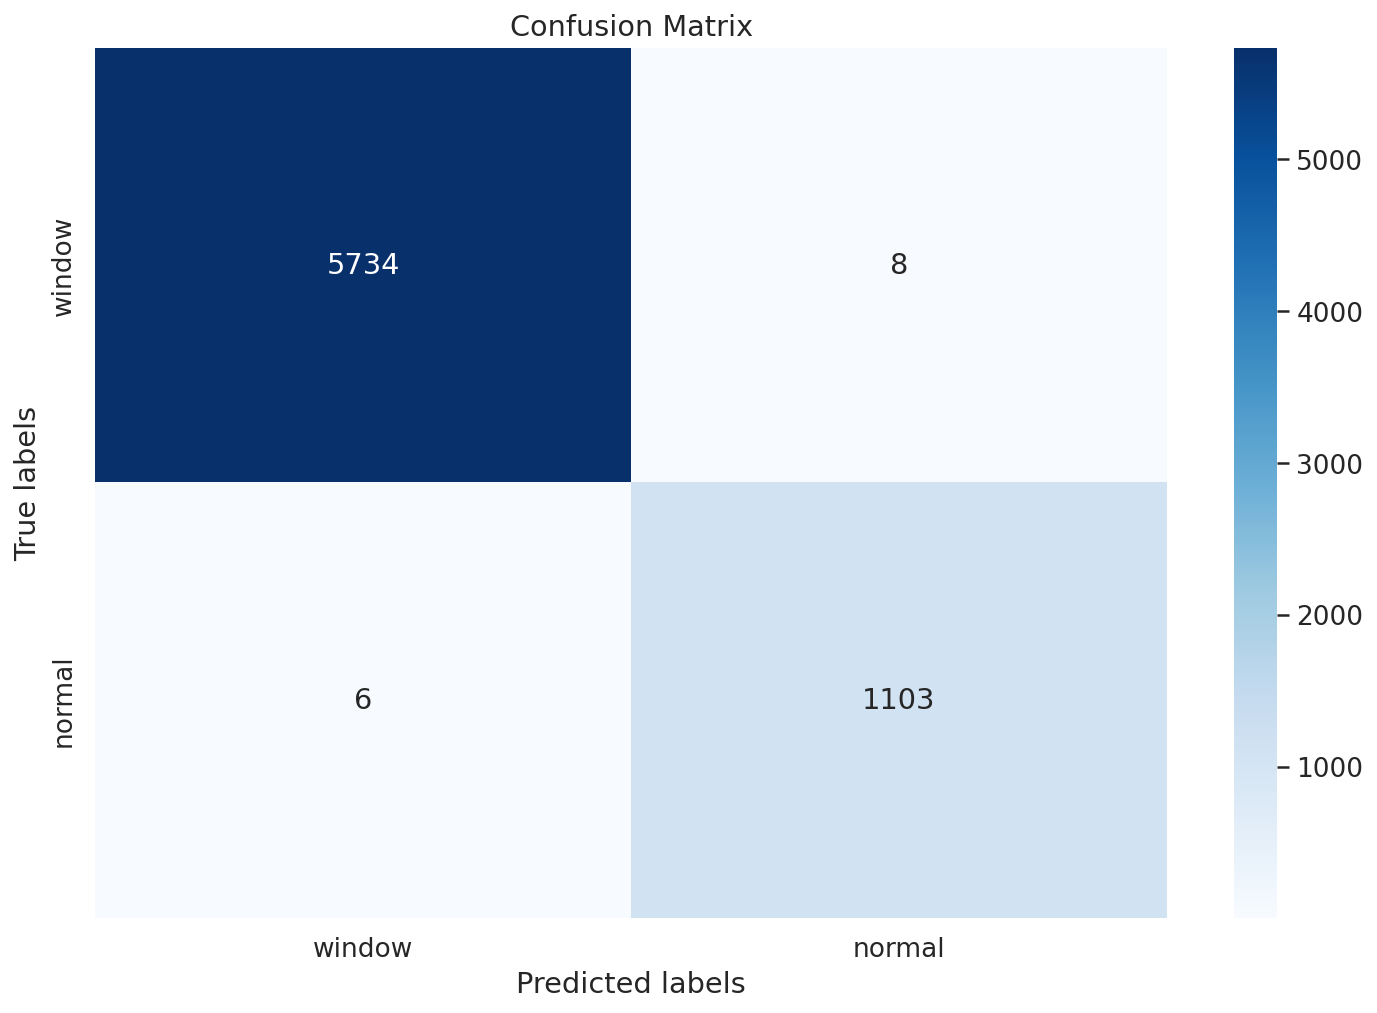

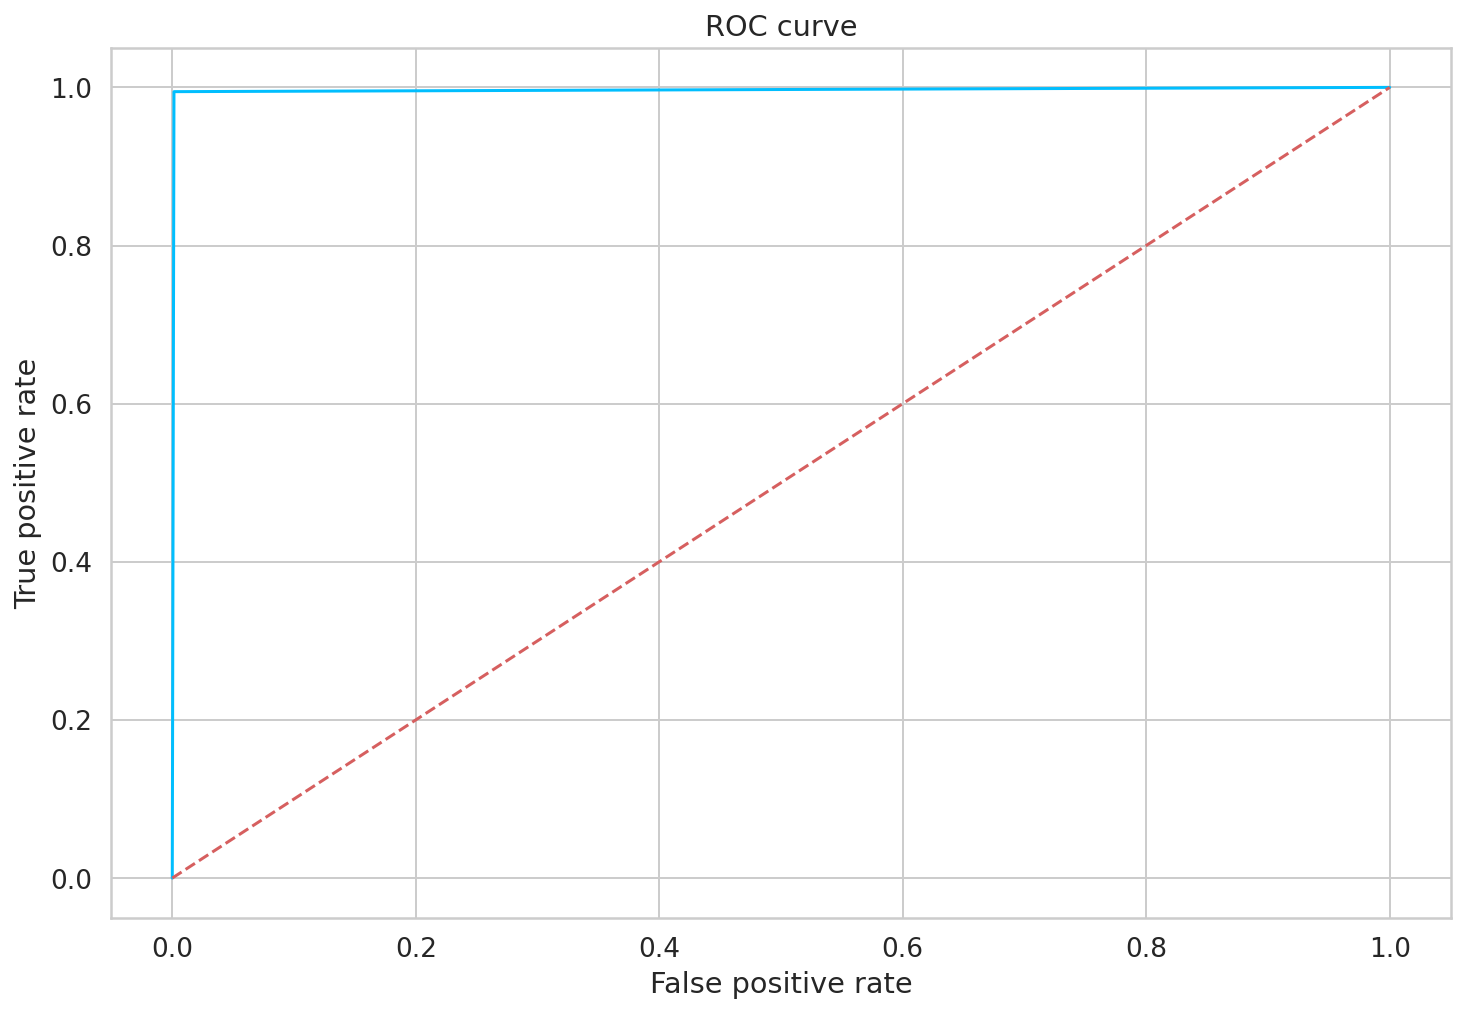

In [ ]:
y_pred = correct_anomaly+correct_normal
y_true = pred_losses_anomaly+pred_losses_normal
# print(y_true)
# print(y_pred)
test_sklearn(y_true, y_pred)

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

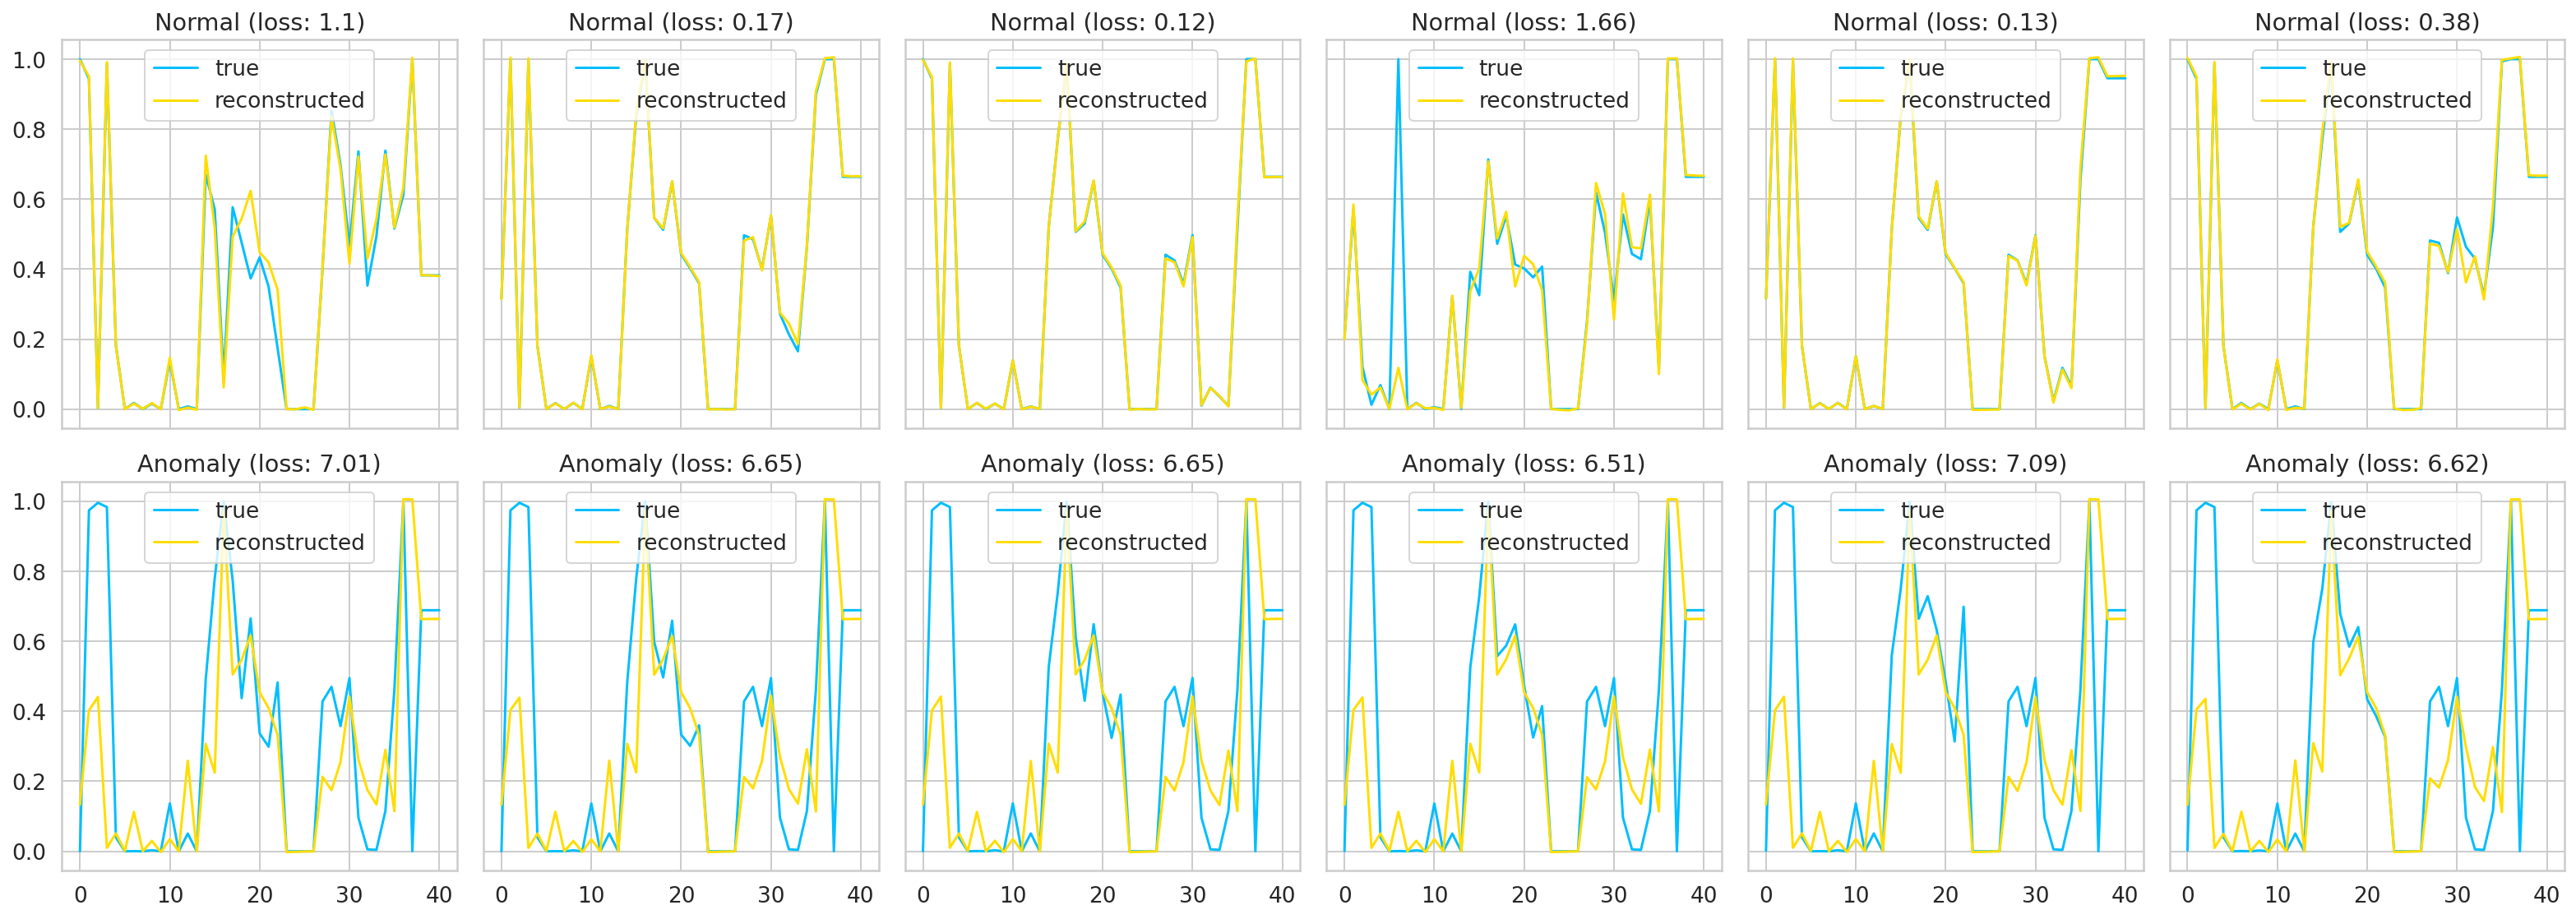

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model,(1,41,1))


Layer (type:depth-idx)                   Output Shape              Param #
RecurrentAutoencoder                     --                        --
├─Encoder: 1-1                           [1, 128]                  --
│    └─LSTM: 2-1                         [1, 41, 256]              265,216
│    └─LSTM: 2-2                         [1, 41, 128]              197,632
├─Decoder: 1-2                           [41, 1]                   --
│    └─LSTM: 2-3                         [1, 41, 128]              132,096
│    └─LSTM: 2-4                         [1, 41, 256]              395,264
│    └─Linear: 2-5                       [41, 1]                   257
Total params: 990,465
Trainable params: 990,465
Non-trainable params: 0
Total mult-adds (M): 40.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 3.96
Estimated Total Size (MB): 4.21

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)

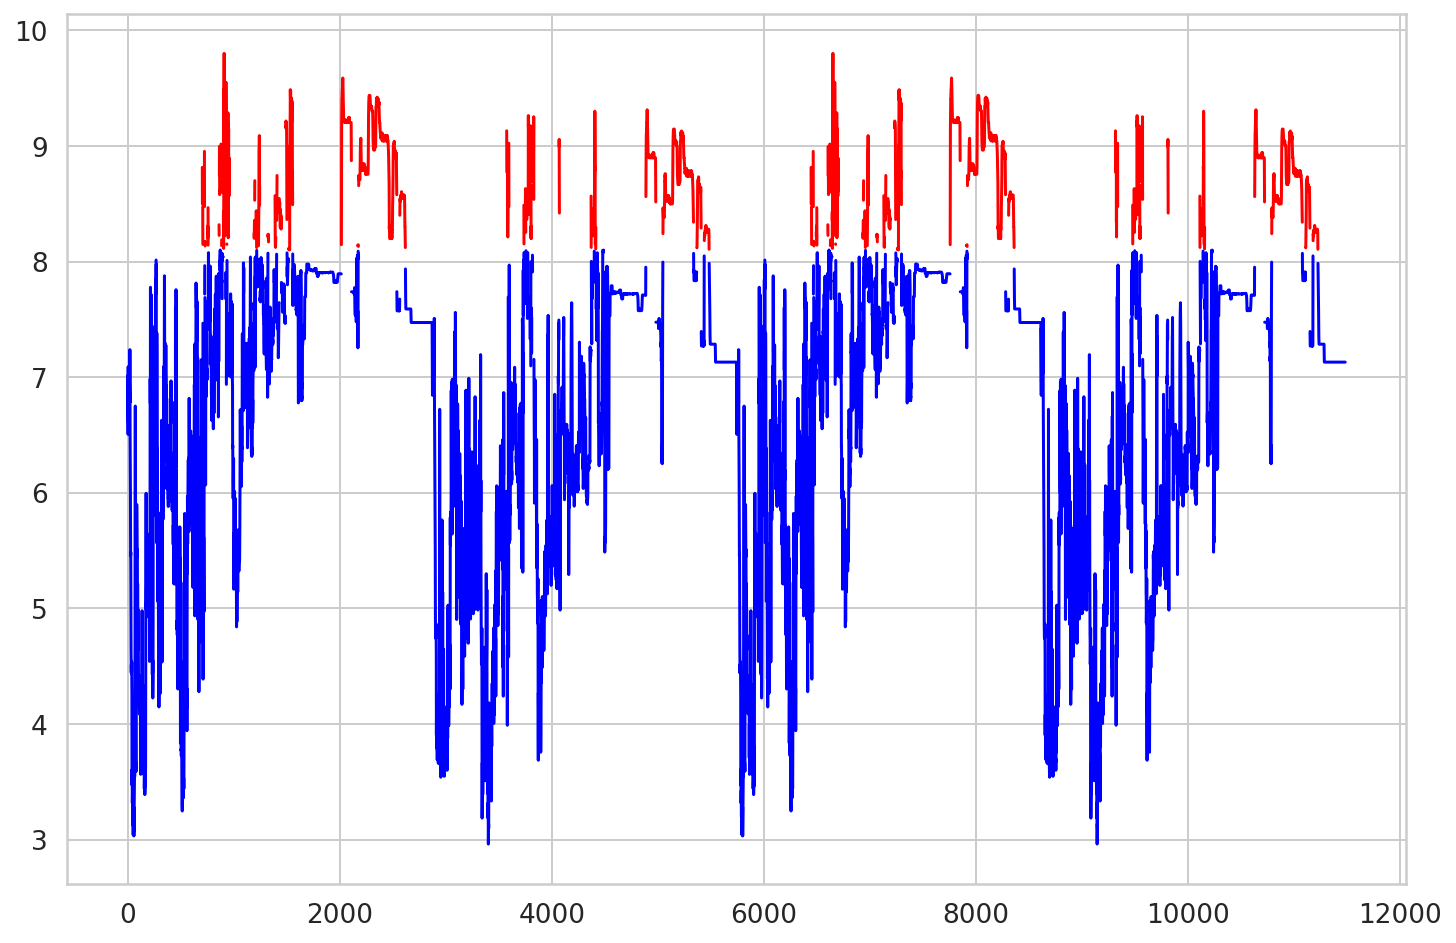

In [ ]:
import matplotlib
plt.gca()

y=[]
y=pred_losses.copy()
y.extend(pred_losses2)

u = np.array(y.copy())
l = np.array(y.copy())

THRESHOLD = 8.1

u[u <= THRESHOLD] = np.nan
l[l >= THRESHOLD] = np.nan

plt.plot(u, color='red')
plt.plot(l, color='blue')